<a href="https://colab.research.google.com/github/akshajbansal/hindi_to_english_translator/blob/main/nlp_competition_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Please refer to competition report submitted for detailed analysis of the model and the citations used for this model. The main citations have been included in this code itself.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#importing modules required in the model
import csv
#for reading csv file (Note csv is in-built module and not an external library which needs to be installed)

from spacy.lang.en import English
#for preprocessing english language

from io import open     #for file management
import sys, unicodedata, string, re, random, torch, math    #other important modules

#including necessary torch functionalities
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable

#including matplotlib for plotting graph
import matplotlib.pyplot as plt

In [ ]:
def read_csv(path):
    with open(path, 'r') as file:         #open csv file at location path
        my_reader = csv.reader(file, delimiter=',')
        cnt = 0
        for row in my_reader:
            if cnt == 0:    cnt += 1        #skips reading headers from csv file
            else:
                if str(path) == train_path:     #if train_path is argument
                    array.append([row[1], row[2]])       #row[0] is index, row[1] is hindi, row[2] is english
                    cnt += 1
                else:                           #if test_path is argument
                    sentences.append(row[2])       #row[0] is index, row[1] is index, row[2] is hindi
                    cnt += 1
    return cnt

In [ ]:
#array to store hindi-english sentence pairs
array = []

In [ ]:
#importing train data from csv file
train_path = 'drive/MyDrive/train.csv'
cnt = read_csv(train_path)
print(f'{cnt-1} sentences read')

102322 sentences read


In [ ]:
#below line is for specifying number of train pairs to be sampled randomly
#array = random.sample(array, 45000)     #sample 45000 data pairs randomly
#since the above line is commented, all data pairs are read
data_hindi = []     #array to store hindi sentences
data_english = []       #array to store english sentences
for i in array:     #splits hindi and english sentences
    data_hindi.append(i[0])
    data_english.append(i[1])

In [ ]:
print(len(data_hindi), len(data_english))
print(data_hindi[:10])
print(data_english[:10])

102322 102322
['एल सालवाडोर मे, जिन दोनो पक्षों ने सिविल-युद्ध से वापसी ली, उन्होंने वही काम किये जो कैदियों की कश्मकश के निदान हैं।', 'मैं उनके साथ कोई लेना देना नहीं है.', '-हटाओ रिक.', 'क्योंकि यह एक खुशियों भरी फ़िल्म है.', 'The thought reaching the eyes...', 'मैंने तुमे School से हटवा दिया .', 'यह Vika, एक फूल है.', 'पर मेरे लिए उसका यहुदी विरोधी होना उसके कार्यों को और भी प्रशंसनीय बनाता है क्योंकि उसके पास भी पक्षपात करने के वही कारण थे जो बाकी फौजियों के पास थे पर उसकी सच जानने और उसे बनाए रखने की प्रेरणा सबसे ऊपर थी', 'नहीं, नहीं, नहीं... ठीक है, हम उह हूँ... हम कार्ड का उपयोग करेंगे.', '- क्या भाषा क्या वे वहाँ बात की?']
["In El Salvador, both sides that withdrew from their civil war took moves that had been proven to mirror a prisoner's dilemma strategy.", 'I have nothing to do with them.', 'Fuck them, Rick.', "Because it's a happy film.", 'The thought reaching the eyes...', 'I got you suspended.', "It's a flower, Vika.", 'But personally, for me, the fact that Picquart was a

In [ ]:
#installing and cloning required items for preprocessing
get_ipython().system('pip install Morfessor')     #Morfessor models Indian languages

#this is the citation for the indicnlp library and resources used
#@misc{
#  kunchukuttan2020indicnlp,
#  author = "Anoop Kunchukuttan",
#  title = "{The IndicNLP Library}",
#  year = "2020",
#  howpublished={\url{https://github.com/anoopkunchukuttan/indic_nlp_library/blob/master/docs/indicnlp.pdf}}
#}
#this citation is given on the webpage which can be accessed by the above/below link

!git clone "https://github.com/anoopkunchukuttan/indic_nlp_library"
!git clone https://github.com/anoopkunchukuttan/indic_nlp_resources.git
INDIC_NLP_LIB_HOME = r"/content/indic_nlp_library"
INDIC_NLP_RESOURCES = "/content/indic_nlp_resources"
sys.path.append(r'{}'.format(INDIC_NLP_LIB_HOME))

Cloning into 'indic_nlp_library'...
remote: Enumerating objects: 1271, done.
remote: Counting objects: 100% (93/93), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 1271 (delta 50), reused 54 (delta 25), pack-reused 1178
Receiving objects: 100% (1271/1271), 9.56 MiB | 16.56 MiB/s, done.
Resolving deltas: 100% (654/654), done.
Cloning into 'indic_nlp_resources'...
remote: Enumerating objects: 133, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 133 (delta 0), reused 2 (delta 0), pack-reused 126
Receiving objects: 100% (133/133), 149.77 MiB | 42.56 MiB/s, done.
Resolving deltas: 100% (51/51), done.


In [ ]:
#importing relevant items from indicnlp
from indicnlp import loader
from indicnlp import common
from indicnlp.tokenize import indic_tokenize 
from indicnlp.normalize.indic_normalize import BaseNormalizer
common.set_resources_path(INDIC_NLP_RESOURCES)
loader.load()

In [ ]:
#enabling cuda for this model
use_cuda = torch.cuda.is_available()

In [ ]:
#tokenizing English using spacy module of python
nlp = English()
tokenizer = nlp.tokenizer

In [ ]:
#defining variables
SOS, EOS, UKN = 0, 1, 2     #start of sentence, end of sentence, unknown

In [ ]:
#tokenize a sentence
#using spacy for english and INDICNLP for hindi
def tokenize_sentence(lang, s):
    return list(tokenizer(s)) if lang.name == 'English' else list(indic_tokenize.trivial_tokenize(s))

In [ ]:
#create indices
#returns index of word in the list if word is found
#returns 2 (the variable index for UKN) if word is not found
def sentence_indices(lang, s):
    return [lang.word2index.get(str(i),2) for i in list(tokenizer(s))] if lang.name == 'English' else [lang.word2index.get(i, 2) for i in list(indic_tokenize.trivial_tokenize(s))]

In [ ]:
#creating variables
#returns array of indices
def sentence_variables(lang, s):
    index = sentence_indices(lang, s)
    index.append(EOS)
    return Variable(torch.LongTensor(index).view(-1, 1)).cuda() if use_cuda else Variable(torch.LongTensor(index).view(-1, 1))

In [ ]:
#creating hindi-english data pairs
#returns hindi-english pairs
def pair_variables(hindi_language, english_language, pair):
    return (sentence_variables(hindi_language, pair[0]), sentence_variables(english_language, pair[1]))

In [ ]:
#creating class Create_Language
class Create_Language:
    def __init__(self, name):
        self.name = name
        self.vocab = 3      #dictionary size (initially 3: SOS, EOS, UKN)
        self.word2index = {}
        self.index2word = {0: "SOS", 1: "EOS", 2: "UKN"}   #start of sentence, end of sentence, unknown

    def add_word(self, word):      #adds new word to dictionary
        if word not in self.word2index:
            self.vocab += 1
            self.word2index[word] = self.vocab-1
            self.index2word[self.vocab-1] = word

In [ ]:
#preparing dictionary
#returns training data pairs
def dictionary(data_hindi, data_english):
    hindi_language, english_language = Create_Language('Hindi'), Create_Language('English')     #creates language
    hindi_sentences, english_sentences = list(data_hindi), list(data_english)     #data from csv file splitted into hindi and english
    train_data_pairs = list(zip(hindi_sentences, english_sentences))        #hindi-english corresponding sentence pairing

    for hindi_sentence, english_sentence in train_data_pairs:       #tokenize sentences and adding words to vocabulary/dictionary
        for token in tokenize_sentence(hindi_language, hindi_sentence):      hindi_language.add_word(token)
        for token in tokenize_sentence(english_language, english_sentence):      english_language.add_word(str(token))
  
    print(f'English has {english_language.vocab} words\nHindi has {hindi_language.vocab} words')
    return hindi_language, english_language, train_data_pairs

In [ ]:
hindi_language, english_language, train_data_pairs = dictionary(data_hindi, data_english)       #displaying number of words read

English has 38349 words
Hindi has 46383 words


In [ ]:
#Encoder Module
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, layers = 1):    #number of layers = 1
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.layers = layers
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        for i in range(self.layers):     output, hidden = self.gru(output, hidden)
        return output, hidden

    def init_hidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        return result.cuda() if use_cuda else result

In [ ]:
#Decoder Module
class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size, layers = 1):       #number of layers = 1
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.layers = layers
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim = 1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        for i in range(self.layers):
            output = F.relu(output)
            output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def init_hidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        return result.cuda() if use_cuda else result

In [ ]:
#initializing encoder and decoder
hidden_size = 1024
encoder = Encoder(hindi_language.vocab, hidden_size)
decoder = Decoder(hidden_size, english_language.vocab)

In [ ]:
#using cuda for encoder and decoder
if use_cuda:      #torch.cuda is available for use
    encoder = encoder.cuda()
    decoder = decoder.cuda()

In [ ]:
#parameters for train data function
teacher_forcing_ratio = 0.6
MAX_LENGTH = 25

In [ ]:
#training data function
def train(input_variable, output_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length = MAX_LENGTH):
    encoder_hidden = encoder.init_hidden()
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_variable.size()[0]
    target_length = output_variable.size()[0]

    encoder_outputs = Variable(torch.zeros(input_length, encoder.hidden_size)).cuda() if use_cuda else Variable(torch.zeros(input_length, encoder.hidden_size))

    loss = 0

    #training encoder
    for en_in in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[en_in], encoder_hidden)
        encoder_outputs[en_in] = encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS]])).cuda() if use_cuda else Variable(torch.LongTensor([[SOS]]))
    decoder_hidden = encoder_hidden

    teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    #training decoder based on teacher_forcing_ratio
    if teacher_forcing:         #target output serves as next input
        for de_in in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            loss += criterion(decoder_output, output_variable[de_in])
            decoder_input = output_variable[de_in]
    else:        #prediction word serves as next input
        for de_in in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            d1, d2 = decoder_output.data.topk(1)
            decoder_input = Variable(torch.LongTensor([[d2[0][0]]])).cuda() if use_cuda else Variable(torch.LongTensor([[d2[0][0]]]))
            loss += criterion(decoder_output, output_variable[de_in])
            if d2[0][0] == EOS:   break

    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [ ]:
#model parameteres and some declarations
learning_rate = 0.006
#losses array is to record loss values per batch_size iterations so that they can be plotted later
losses = []
total_loss = 0

In [ ]:
#number of iterations for train phase
iterations = 12800
#number of epochs for train phase
epochs = 10
batch_size = 400

In [ ]:
encoder_optimizer = optim.SGD(encoder.parameters(), lr = learning_rate)
decoder_optimizer = optim.SGD(decoder.parameters(), lr = learning_rate)
train_data_pairs = random.sample(train_data_pairs, iterations)
training_pairs = [pair_variables(hindi_language, english_language, train_data_pairs[iter]) for iter in range(iterations)]      #randomly selects 12800 data pairs
criterion = nn.NLLLoss()

In [ ]:
#function to calculate loss for training phase of the model
def calculate_loss(iter, batch_size):
    training_pair = training_pairs[iter]
    input_variable, output_variable = training_pair[0], training_pair[1]
    loss = train(input_variable, output_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
    return loss

Epoch 1:
    Iterations (400/12800) have an average loss of 3.556526342712778
    Iterations (800/12800) have an average loss of 3.6408736333183556
    Iterations (1200/12800) have an average loss of 3.63722895823655
    Iterations (1600/12800) have an average loss of 3.492270237183564
    Iterations (2000/12800) have an average loss of 3.6894716835042396
    Iterations (2400/12800) have an average loss of 3.6188794738283083
    Iterations (2800/12800) have an average loss of 3.530993393659386
    Iterations (3200/12800) have an average loss of 3.38150592900412
    Iterations (3600/12800) have an average loss of 3.7084702504942486
    Iterations (4000/12800) have an average loss of 3.487055985770064
    Iterations (4400/12800) have an average loss of 3.603846483180705
    Iterations (4800/12800) have an average loss of 3.4356631166074942
    Iterations (5200/12800) have an average loss of 3.493178861771633
    Iterations (5600/12800) have an average loss of 3.649798981984272
    Iterat

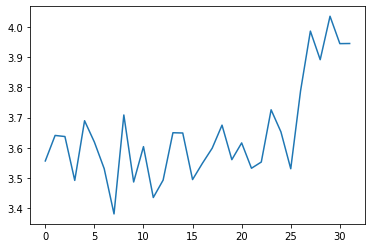

In [ ]:
#training phase for the model
#note that this model trains on 1 data per iteration for 12800 iterations using SGD for 10 epochs
for epoch in range(epochs):     #number of epochs
    if epoch == 4:      #early stopping since loss increases afterwards
        break
    print(f'Epoch {epoch+1}:')
    for iter in range(iterations):      #iterations = 12800 per epoch
        total_loss += calculate_loss(iter, batch_size)
        if (iter+1) % batch_size == 0:      #calculates average loss per batch_size = 400 iterations
            avg_loss = total_loss / batch_size
            losses.append(avg_loss)
            total_loss = 0
            print(f'    Iterations ({iter+1}/{iterations}) have an average loss of {avg_loss}')
    plt.plot(losses)        #plots points on graph and connects them sequentially for each epoch
    losses = []         #losses array again initialized to [] for next epoch
    #comment above line if you want cotinuous plot of loss function and not loss per epoch

In [ ]:
#function for testing data
def evaluate(encoder, decoder, sentence, max_length = MAX_LENGTH):
    input_variable = sentence_variables(hindi_language, sentence)
    input_length = input_variable.size()[0]
    encoder_hidden = encoder.init_hidden()
    encoder_outputs = Variable(torch.zeros(input_length, encoder.hidden_size)).cuda() if use_cuda else Variable(torch.zeros(input_length, encoder.hidden_size))

    #test input enters encoder
    for en_in in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[en_in], encoder_hidden)
        encoder_outputs[en_in] += encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS]])).cuda() if use_cuda else Variable(torch.LongTensor([[SOS]]))
    decoder_hidden = encoder_hidden
    decoded_words = []

    #test input enters decoder
    for de_in in range(max_length):
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
        d1, d2 = decoder_output.data.topk(1)
        if d2[0][0].item() != EOS:
            decoded_words.append(english_language.index2word[d2[0][0].item()])
        else:
            break
        decoder_input = Variable(torch.LongTensor([[d2[0][0].item()]])).cuda() if use_cuda else Variable(torch.LongTensor([[d2[0][0].item()]]))

    return decoded_words

In [ ]:
#computing output using evaluate and store the result in translation
def compute_translation(sentences):
    translation = ""     #stores translated sentences in output with each sentence separated by \n character
    for sentence in sentences:
        translated_sentence = ' '.join(evaluate(encoder, decoder, sentence))
        translated_sentence += "\n"
        translation += translated_sentence
    return translation

In [ ]:
#writes output to answer.txt
def write_output(output_path, translation):
    f = open(output_path,"w")
    f.write(translation)
    f.close()

In [ ]:
#test phase of the model
test_path = 'drive/MyDrive/testhindistatements.csv'

sentences = []
cnt = read_csv(test_path)
print(f'{cnt-1} sentences read')

translation = compute_translation(sentences)

24102 sentences read


In [ ]:
print(sentences[:4])

['(तालियां) अब, इसने मेरे मन को उड़ा दिया।', 'पर आप बहुत धाँसू लग रहे हैं।', 'शास्त्र समझ्ने के रा स्ते बनाती है|', 'कृपया मेरी बात सुनो।']


In [ ]:
output_path = 'answer.txt'
write_output(output_path, translation)

In [ ]:
#saving encoder and decoder model used for training
model = 'encoder.pt'
path = F"/content/drive/MyDrive/{model}" 
torch.save(encoder.state_dict(), path)
model = 'decoder.pt'
path = F"/content/drive/MyDrive/{model}" 
torch.save(decoder.state_dict(), path)

I would like to cite the following webpage from which I took help to write the above code:

S.R. (2017). NLP FROM SCRATCH: TRANSLATION WITH A SEQUENCE TO SEQUENCE NETWORK AND ATTENTION. Pytorch.Org. https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

I would like to mention that I have used some parts from the above source and modified them according to my needs. Moreover, the above source used attention decoder which I did not use in my model. However, the encoder and decoder module which I implemented are quite similar in their functionality because I used the same architecture as the webpage: GRU, ReLu, softmax and NLL loss. I could not try other functions because the model took a large time to run and I also had to find the best hyperparameters for the model.

I also used python documentations for pytorch and other stuffs from the main python documentation webpage.